# More diagnostics to check whether simulations and resampled realization are similar

In [85]:
assert <- stopifnot

In [86]:
kineticEnergy <- function(m, vx, vy, vz)
{
    M <- sum(m)
    vx <- vx - sum(m*vx)/M
    vy <- vy - sum(m*vy)/M
    vz <- vz - sum(m*vz)/M    
    K = sum(0.5*m*(vx*vx + vy*vy + vz*vz))
    return(K)
}

Assuming units are Solar masses, parsecs, and km/s; G should be 4.302 x 10^-3

In [87]:
classicPotential <- function(m, x, y, z, G = 4.302/1000.0)
{
    assert(min(m) >= 0.0)
    assert(length(x) == length(m))    
    id <- 1:length(m)
    V <- sum(sapply(id, function(i) {
        sum(sapply(id, function(j) {
            if(j > i)
            {
                rij <- sqrt((x[i] - x[j])*(x[i] - x[j]) + (y[i] - y[j])*(y[i] - y[j]) + (z[i] - z[j])*(z[i] - z[j]))
                return(- G*m[i]*m[j]/rij)
            }
            return(0.0)
        }))
    }))
    assert(V <= 0.0)
    return(V)
}

In [88]:
classicPotentialScaleCutoff <- function(m, x, y, z, h, G = 4.302/1000.0)
{
    assert(min(m) >= 0.0)
    assert(length(x) == length(m))    
    id <- 1:length(m)
    V <- sum(sapply(id, function(i) {
        sum(sapply(id, function(j) {
            if(j > i)
            {
                rij <- sqrt((x[i] - x[j])*(x[i] - x[j]) + (y[i] - y[j])*(y[i] - y[j]) + (z[i] - z[j])*(z[i] - z[j]))
                if(rij < h) #disregard energies at scales below h
                {
                    v <- 0
                }
                else
                {
                    v <- -G*m[i]*m[j]/rij
                }
                return(v)
            }
            return(0.0)
        }))
    }))
    assert(V <= 0.0)
    return(V)
}

In [89]:
momentOfInertia <- function(m, x, y, z)
{
    M <- sum(m)
    x <- x - sum(m*x)/M
    y <- y - sum(m*y)/M
    z <- z - sum(m*z)/M
    r <- sqrt(x*x + y*y + z*z)
    I <- 0.5*sum(m*r*r)
    return(I)
}

In [90]:
barbourStructureIndicator <- function(m, x, y, z)
{
    B <- sqrt(momentOfInertia(m, x, y, z))*classicPotential(m, x, y, z)
    return(B)
}

In [95]:
totalEnergyAndVirial <- function(m, x, y, z, vx, vy, vz, h, G=4.302/1000.0)
{
    K <- kineticEnergy(m, vx, vy, vz)
    V <- classicPotential(m, x, y, z)
    Vcutoff <- classicPotentialScaleCutoff(m, x, y, z, h)
    I <- momentOfInertia(m, x, y, z)
    B <- barbourStructureIndicator(m, x, y, z)
    distanceSummary <- summary(dist(data.frame(x,y,z)))
    return(list(K=K, V=V, Vcutoff = Vcutoff, E=K+V, virial=2*K+V, virialRatio = K/V, I = I, B = B, distanceSummary = distanceSummary))
}

In [103]:
distanceCompare <- function(simulation, realization)
{
    dSimulation <- dist(simulation[,2:4])
    dRealization <- dist(realization[,2:4])
    qqplot(log10(dSimulation), log10(dRealization), main = "", pch = 16, cex = 0.5, xlab = "Log pairwise distances (simulation)", ylab = "Log pairwise distances (realization)")
    abline(0,1,col = "#F63169")
}

Read in the simulation and two realizations. Plot the quantiles of pairwise distances against each other. If they had the same distribution they would straddle the diagonal line. They don't. They seem closer to the line when plotting two realizations against each other than when plotting the original simulation against one realization. Which is especially BAD.

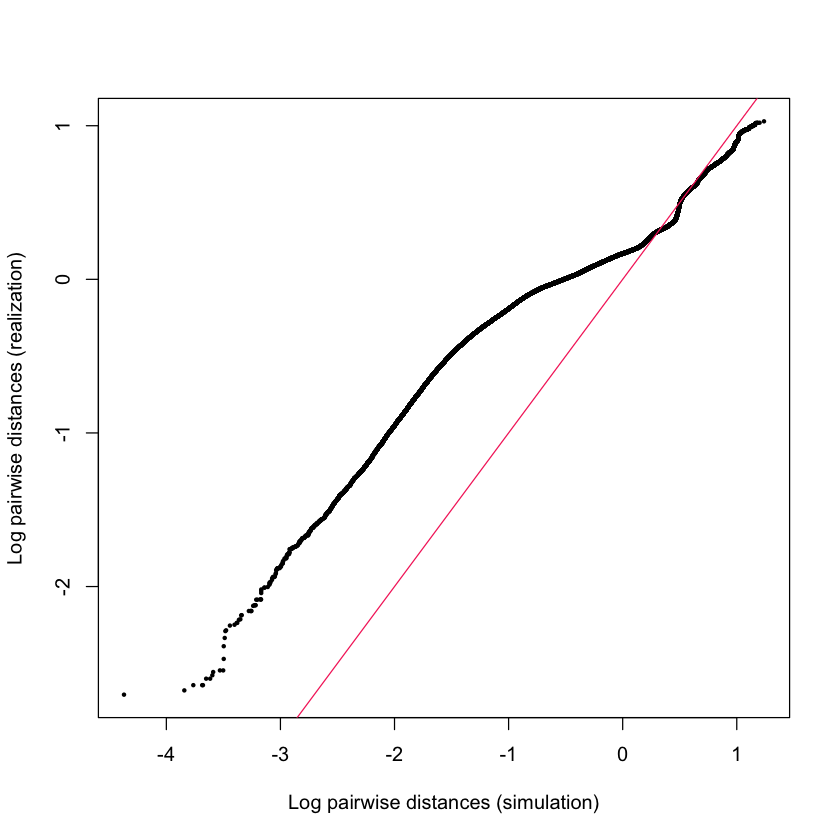

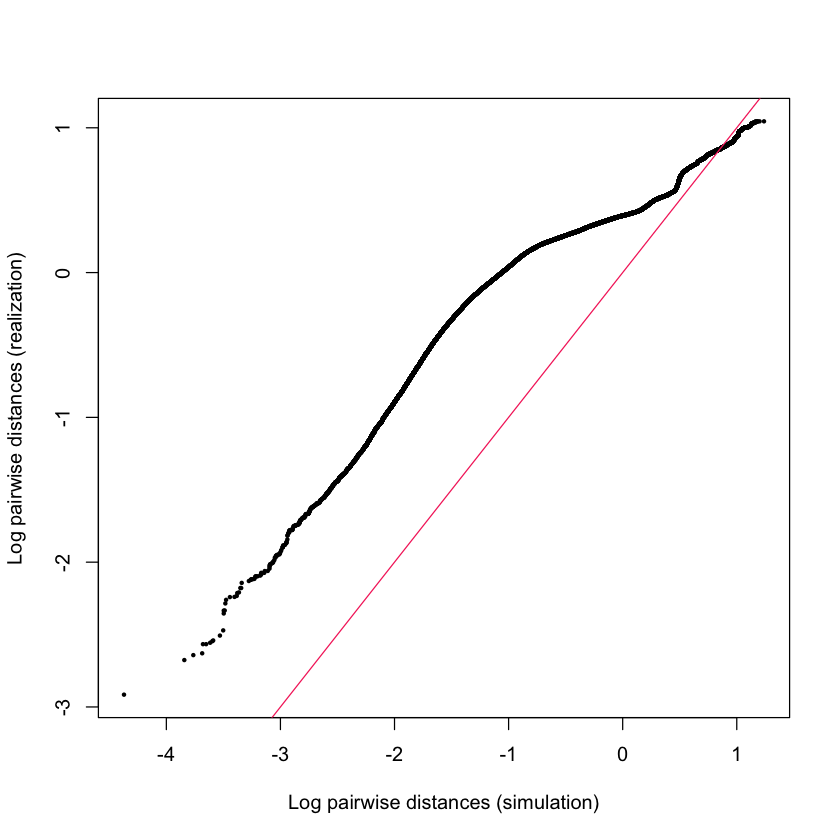

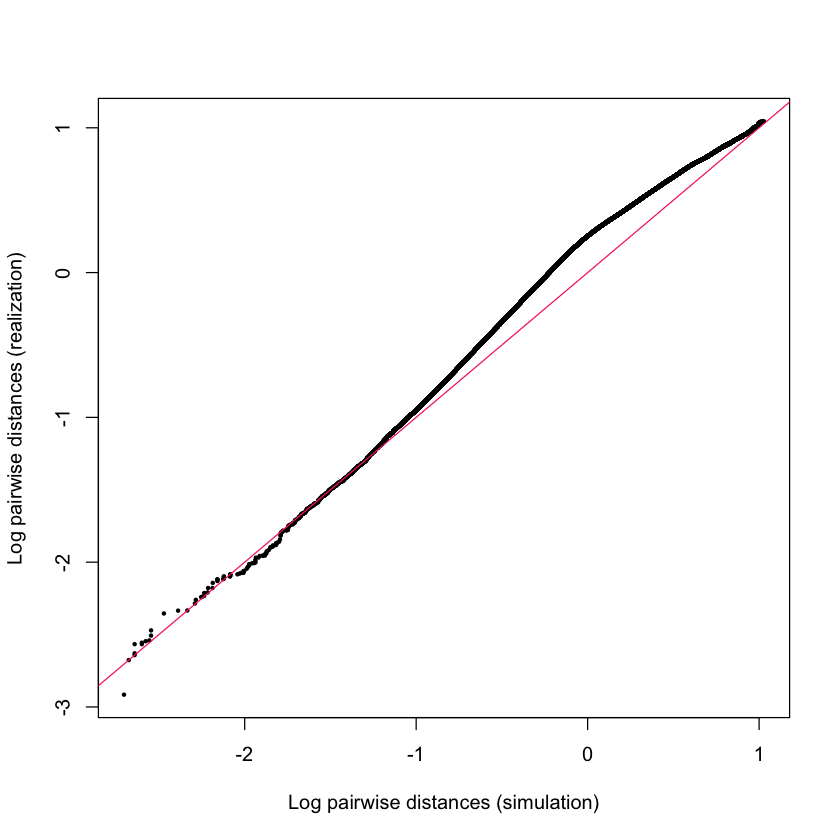

In [104]:
simulation <- read.table("Sink/sink_m1.e4.dat")
realizationA <- read.table("Seed/new_stars_seed_19.dat")
realizationB <- read.table("Seed/new_stars_seed_293.dat")

distanceCompare(simulation, realizationA)
distanceCompare(simulation, realizationB)
distanceCompare(realizationA, realizationB)

Calculate also the potential energy due to scales above a cutoff (h, here h=0.1 pc; this is equivalent to turning all the clumps smaller than 0.1 pc into single particles). Note how with the cutoff the potential energy of the simulation and of the realizations is more similar.

In [97]:
allStats <- function(df) totalEnergyAndVirial(df[,1], df[,2], df[,3], df[,4], df[,5], df[,6], df[,7], 0.1)

In [98]:
allStats(simulation)

$K
[1] 97282.8

$V
[1] -162942.8

$Vcutoff
[1] -38783.48

$E
[1] -65660.05

$virial
[1] 31622.76

$virialRatio
[1] -0.5970363

$I
[1] 8995.196

$B
[1] -15453990

$distanceSummary
     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
 0.000043  0.797502  2.239421  2.332592  3.167466 17.324261 


In [99]:
allStats(realizationA)

$K
[1] 130099.7

$V
[1] -26210.39

$Vcutoff
[1] -25362.07

$E
[1] 103889.3

$virial
[1] 233989

$virialRatio
[1] -4.963668

$I
[1] 7503.606

$B
[1] -2270432

$distanceSummary
     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
 0.001978  1.374541  2.127444  2.381740  3.114110 10.680344 


In [100]:
allStats(realizationB)

$K
[1] 114162.8

$V
[1] -16625.27

$Vcutoff
[1] -15657.74

$E
[1] 97537.57

$virial
[1] 211700.4

$virialRatio
[1] -6.866827

$I
[1] 15303.66

$B
[1] -2056678

$distanceSummary
     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
 0.001216  2.343871  3.334442  3.500699  4.518104 11.081258 
